# Set up

In [14]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.metrics.intrinsic_dimension import IntrinsicDimension
from src.metrics.clustering import LabelClustering
from src.metrics.overlap import PointOverlap
from src.utils.tensor_storage import retrieve_from_storage
import numpy as np
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import pandas as pd
plot_config = {
    'axes.titlesize': 30,      
    'axes.labelsize': 29,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 23,
    'figure.figsize': (10, 8),
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
}

In [15]:
model_name = "mistral-1-7b"

title = model_name
title = title.replace("-", " ")
title = title[0].upper() + title[1:]

_PATH_ft = Path(f"/orfeo/cephfs/scratch/area/ddoimo/open"\
                f"/geometric_lens/repo/results"\
                f"/finetuned_dev_val_balanced_40samples"\
                f"/evaluated_test/{model_name}/6epochs/epoch_6")

_PATH = Path(f"/orfeo/cephfs/scratch/area/ddoimo/open/geometric_lens"
             f"/repo/results/evaluated_test/random_order/{model_name}")

_CACHE_PATH = Path(f"cache/{model_name}/")
_CACHE_PATH.mkdir(parents=True, exist_ok=True)

In [16]:
def find_num_shot(path):
    if "70b" in path:
        return 4
    else:
        return 5
def average_custom_blocks(y, n):
    """
    For the plots in the main section of the paper we average the value of a certain metric for a specific layer
    over a window of n layers. This is done in order to smooth the profile.
    """
    if n==0:
        return y
    # Initialize lists to store averages
    y_avg = []

    # Handle the first block [0:n]
    
    y_avg.append(np.mean(y[0:n]))
    
    # Handle the second block [0:n+1]
    if len(y) > n:
        
        y_avg.append(np.mean(y[0:n+1]))

    # Handle subsequent blocks [i:n+i] starting from i=1
    for i in range(1, len(y)-1):
        
        y_avg.append(np.mean(y[i:n+i+1]))
    assert len(y_avg) == len(y), f"y_avg:{len(y_avg)}, y:{len(y)}"

    return np.array(y_avg)


def plotter(file_name,
            data,
            title,
            ylabel,
            yticks=None,
            avg=0):
    
    # Set the style
    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
    )
    # Setup figure and axes for 2 plots in one row
    plt.figure(dpi=200)
    layers = np.arange(0, data[0].shape[0])

    # Set ticks
    if layers.shape[0] < 50:
        # Generates positions 0, 4, 8, ...
        tick_positions = np.arange(0, layers.shape[0], 4)  
    else:
        # Generates positions 0, 4, 8, ...
        tick_positions = np.arange(0, layers.shape[0], 8)  

    tick_labels = tick_positions + 1  # Get the corresponding labels from x

    names = ["0 shot pt",
             "1 shot pt",
             "2 shot pt",
             "5 shot pt",
             "0 shot ft"]
    markerstyle = ['o', 'o', 'o', 'o', 'x']
   
    for int_dim, label, markerstyle in zip(data, names, markerstyle):
        int_dim = average_custom_blocks(int_dim, avg)
        sns.scatterplot(x=layers, y=int_dim, marker=markerstyle)
        sns.lineplot(x=layers, y=int_dim, label=label)

    plt.xlabel("Layer")
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if yticks:
        plt.xticks(ticks=tick_positions, labels=tick_labels)
        if isinstance(yticks, list):
            tick_positions_y = np.arange(yticks[0], (yticks[1] + (yticks[1]-yticks[0])/10),
                                         (yticks[1]-yticks[0])/10).round(2)
        else:
            tick_positions_y = np.arange(0, (yticks + yticks/10), yticks/10).round(2)
        plt.yticks(tick_positions_y)
    plt.tick_params(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.rcParams.update(plot_config)

    # setting fi
    file_name = file_name.replace(" ", "_")
    if ylabel == "ARI":
        file_name = file_name + "_1.6"
    # file_name = file_name + "_"+model
    file_name = file_name + "_avg_" + str(avg) if avg > 0 else file_name    
    file_name = file_name + "_no_title" if not title else file_name
    if title:
        path = Path(f"plots/{file_name}.pdf")
        path.parent.mkdir(parents=True, exist_ok=True)
        # plt.savefig(f"plots/{file_name}.png")
        plt.savefig(path, format='pdf')
    else:
        path = Path(f"plots/no_title/{file_name}.pdf")
        path.parent.mkdir(parents=True, exist_ok=True)
        # plt.savefig(f"plots/no_title/{file_name}.png")
        plt.savefig(path, format='pdf')
    plt.show()


In [17]:
# size of the window for the average
AVG = 2

# List of metrics used in the paper
_METRICS = ["intrinsic_dimension",
            "clustering_subject",
            "clustering_letter",
            "clusters_analysis",
            "dynamics_of_finetuning"]

# Paper results 
The following snippet can be used to replicate some of the plot from the paper

## Intrinsic Dimension

In [18]:
if "intrinsic_dimension" in _METRICS:
    print("Intrinsic Dimension")

    shot = [0, 1, 2, find_num_shot(str(_PATH))]
    data = []

    if os.path.exists(_CACHE_PATH / "intrinsic_dim.pkl"):
        print("Loading from cache")
        with open(_CACHE_PATH / "intrinsic_dim.pkl", "rb") as f:
            data = pickle.load(f)
    else:
        for i in shot:
            out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                                     full_tensor=True,
                                                     instances_per_sub=200)
            tensors, _, number_of_layers = out_from_storage
            intrinsic_dim = IntrinsicDimension()
            
            data.append(intrinsic_dim.main(tensors, number_of_layers))

        out_from_storage = retrieve_from_storage(_PATH_ft,
                                                 full_tensor=True,
                                                 instances_per_sub=200)
        tensors, _, number_of_layers = out_from_storage
        intrinsic_dim = IntrinsicDimension()
        data.append(intrinsic_dim.main(tensors, number_of_layers))
        with open(_CACHE_PATH / "intrinsic_dim.pkl", "wb") as f:
            pickle.dump(data, f)
    
    # Selecting the order of nearest neighbors considered in gride
    data_nn_index = [arr[:, -3] for arr in data]
    plotter(file_name="ID/"+model_name, data=data_nn_index, title=title, ylabel="ID", avg=0, yticks=22)
    plotter(file_name="ID/"+model_name, data=data_nn_index, title=title, ylabel="ID", avg=AVG, yticks=22)
    print("Intrinsic Dimension done")

Intrinsic Dimension


Processing layers: 100%|██████████| 31/31 [00:00<00:00, 64.95it/s]


## Clustering

### Subjects

In [ ]:
if "clustering_subject" in _METRICS:
    print("Clustering Subject")
    shot = [0, 1, 2, find_num_shot(str(_PATH))]
    data_subjects = []

    if os.path.exists(_CACHE_PATH / "subject.pkl"):
        print("Loading from cache")
        with open(_CACHE_PATH / "subject.pkl", "rb") as f:
            data_subjects = pickle.load(f)
    else:
        for i in shot:
            clustering = LabelClustering()
            out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                                     full_tensor=True,
                                                     instances_per_sub=200)
            tensors, labels, number_of_layers = out_from_storage
            data_subjects.append(clustering.main(
                z=1.68,
                tensors=tensors,
                labels=labels["subjects"],
                number_of_layers=number_of_layers
                )
            )
            
        clustering = LabelClustering()
        out_from_storage = retrieve_from_storage(_PATH_ft,
                                                 full_tensor=True,
                                                 instances_per_sub=200)
        tensors, labels, number_of_layers = out_from_storage
        data_subjects.append(clustering.main(z=1.68,
                                             tensors=tensors,
                                             labels=labels["subjects"],
                                             number_of_layers=number_of_layers))

        with open(_CACHE_PATH / "subject.pkl", "wb") as f:
            pickle.dump(data_subjects, f)

    ari = [np.array(i['adjusted_rand_score']) for i in data_subjects]

    plotter(file_name="ari_subjects/"+model_name, data=ari, title=title,
            ylabel="ARI", avg=0, yticks=0.9)
    plotter(file_name="ari_subjects/"+model_name, data=ari, title=title,
            ylabel="ARI", avg=AVG, yticks=0.9)
    print("Clustering Subject done")


### Letters

In [ ]:
if "clustering_letter" in _METRICS:
    print("Clustering Letters")
    shot = [0, 1, 2, find_num_shot(str(_PATH))]
    data_letter = []

    if os.path.exists(_CACHE_PATH / "letter.pkl"):
        print("Loading from cache")
        with open(_CACHE_PATH / "letter.pkl", "rb") as f:
            data_letter = pickle.load(f)
    else:
        for i in shot:
            clustering = LabelClustering()
            out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                                     full_tensor=True,
                                                     instances_per_sub=200)
            tensors, labels, number_of_layers = out_from_storage
            data_letter.append(clustering.main(
                z=1.68,
                tensors=tensors,
                labels=labels["predictions"],
                number_of_layers=number_of_layers
                )
            )
                
        clustering = LabelClustering()
        out_from_storage = retrieve_from_storage(_PATH_ft,
                                                 full_tensor=True,
                                                 instances_per_sub=200)
        tensors, labels, number_of_layers = out_from_storage
        data_letter.append(clustering.main(
            z=1.68,
            tensors=tensors,
            labels=labels["predictions"],
            number_of_layers=number_of_layers
            )
        )
        
        with open(_CACHE_PATH / "letter.pkl", "wb") as f:
            pickle.dump(data_letter, f)

    ari = [np.array(i['adjusted_rand_score']) for i in data_letter]
    plotter(file_name="ari_letters/"+model_name, data=ari, title=title,
            ylabel="ARI", yticks=0.5, avg=0)
    plotter(file_name="ari_letters/"+model_name, data=ari, title=title,
            ylabel="ARI", yticks=0.5, avg=AVG)
    print("Clustering Letters done")


### Clusters Analysis

For the following analysis we need to identify core points for each cluster, so we recompute the clustering with `halo==True`

In [ ]:
if "clusters_analysis" in _METRICS:
    print("Clusters analysis")
    shot = [0, 1, 2, find_num_shot(str(_PATH))]
    data_subjects_halo = []
    
    if os.path.exists(_CACHE_PATH / "subject_halo.pkl"):
        print("Loading from cache")
        with open(_CACHE_PATH / "subject_halo.pkl", "rb") as f:
            data_subjects_halo = pickle.load(f)
    else:
        for i in shot:
            clustering = LabelClustering()
            out_from_storage = retrieve_from_storage(_PATH / f'{i}shot',
                                                     full_tensor=True,
                                                     instances_per_sub=200)
            tensors, labels, number_of_layers = out_from_storage
            data_subjects_halo.append(clustering.main(
                z=1.68,
                tensors=tensors,
                labels=labels["subjects"],
                halo=True,
                number_of_layers=number_of_layers,
                )
            )
        
        with open(_CACHE_PATH / "subject_halo.pkl", "wb") as f:
            pickle.dump(data_subjects_halo, f)

        clustering = LabelClustering()
        out_from_storage = retrieve_from_storage(_PATH_ft,
                                                 full_tensor=True)
        tensors, labels, number_of_layers = out_from_storage
        data_subjects_halo.append(clustering.main(
            z=1.68,
            tensors=tensors,
            labels=labels["subjects"],
            halo=True,      
            number_of_layers=number_of_layers,
            )
        )
        with open(_CACHE_PATH / "subject_halo.pkl", "wb") as f:
            pickle.dump(data_subjects_halo, f)
    ari = [np.array(i['adjusted_rand_score']) for i in data_subjects]

    label_clustering = LabelClustering()
    
    # set env variable
    # os.environ["OPENBLAS_NUM_THREADS"] = "128"
    metrics_subject = label_clustering.compute_additional_metrics(
        data_subjects_halo
        )

    num_clusters = metrics_subject["num_clusters"].to_list()
    plotter(file_name="number_clusters/"+model_name+"-num-cluster", data=num_clusters,
            title=title, ylabel="Number of Clusters", avg=0, yticks=[15, 80])
    plotter(file_name="number_clusters/"+model_name+"-num-cluster", data=num_clusters,
            title=title, ylabel="Number of Clusters", avg=AVG, yticks=[15, 80])

    num_clusters = metrics_subject["num_assigned_points"].to_list()
    plotter(file_name="core_points/"+model_name+"-num-ass-point", data=num_clusters,
            title=title, ylabel="Core Point Fraction", avg=0, yticks=[0.1, 0.65])
    plotter(file_name="core_points/"+model_name+"-num-ass-point", data=num_clusters,
            title=title, ylabel="Core Point Fraction", avg=AVG, yticks=[0.1, 0.65])
    print("Clusters analysis done")


# Dynamics of fine tuning

In [ ]:
def plot_overlap(data, title, avg=0):
    
    data = [average_custom_blocks(data[i], avg) for i in range(len(data))]

    # Set up plot styles
    sns.set_style("whitegrid")
    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
        )
    
    # Initialize figure
    plt.figure(dpi=200)
    layers = np.arange(1, data[0].shape[0])
    
    #steps1 = [1, 2, 3, 6, 12, 22, 42, 77, 144, 268]
    # steps2 = [1, 2, 3, 5, 9, 16, 29, 50, 88, 153]
    # steps1 = [1, 2, 4, 9, 19, 40, 83, 173, 360, 752]
    steps1 = [1, 2, 4, 9, 19, 40, 83, 173, 360, 752]
    steps = [1, 2, 3, 6, 11, 19, 35, 63, 114, 206]
#    steps2 = [1, 2, 4, 7, 13, 24, 44, 84, 158, 296]
    # selecting [2, 6, 12, 22, 42, 268] from steps1
    #index = [1, 3, 4, 5, 6, 7, 8]
    index = [0, 3, 4, 5, 6, 7, 9]
    # selecting [2, 5, 16, 29, 50, 153] from steps2
    index_2 = [1, 3, 5, 6, 7, 9]
    
    
    steps = [steps1[i] for i in index]
    data = [data[i] for i in index]
    # steps2 = [steps2[i] for i in index_2]
    # data2 = [data[i] for i in index_2]
    
    # steps = steps2 if "70" in title\
    #     else steps1
    # data = data if "70" in title\
    #     else data
    
    labels = [f"step {step}" for step in steps]
    labels = [1, 7, 14, 27, 52, 101,  376]
    alphas = [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    alphas = np.linspace(0.2, 1, len(steps))
    for label, overlap, alpha in zip(labels, data, alphas):
        sns.lineplot(x=layers, y=overlap[1:], label=label, color="C0", alpha=alpha)
        sns.scatterplot(x=layers, y=overlap[1:], color="C0", alpha=alpha)
        # sns.lineplot(x=layers, y=overlap[1:], label=label)
        # sns.scatterplot(x=layers, y=overlap[1:])
    
    
    # Finalizing plot
    if layers.shape[0] < 50:
        tick_positions = np.arange(1, layers.shape[0], 4)  # Generates positions 0, 4, 8, ...
    else:
        tick_positions = np.arange(1, layers.shape[0], 8)  # Generates positions 0, 4, 8, ...
    # tick_positions = np.arange(1, layers.shape[0], 4)  # Generates positions 0, 4, 8, ...
    tick_labels = tick_positions  # Get the corresponding labels from x
    plt.xticks(ticks=tick_positions, labels=tick_labels)
    #plt.yticks(ticks=np.arange(0.1, 1.1, 0.1).round(3), labels=np.arange(0.1, 1.1, 0.1).round(3))
    plt.xlabel("layer")
    plt.ylabel("layer similarity")
    plt.legend()
    title = title.replace("-", " ")
    plt.title(title)
    plt.tight_layout()
    plt.rcParams.update(plot_config)
    result_path = Path(f"pics-report/chkp_overlap/point_clustering/")
    result_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(result_path / f"{title.lower().replace(' ', '_')}_{avg}.png")
    plt.savefig(result_path / f"{title.lower().replace(' ', '_')}_{avg}.pdf", format="pdf")

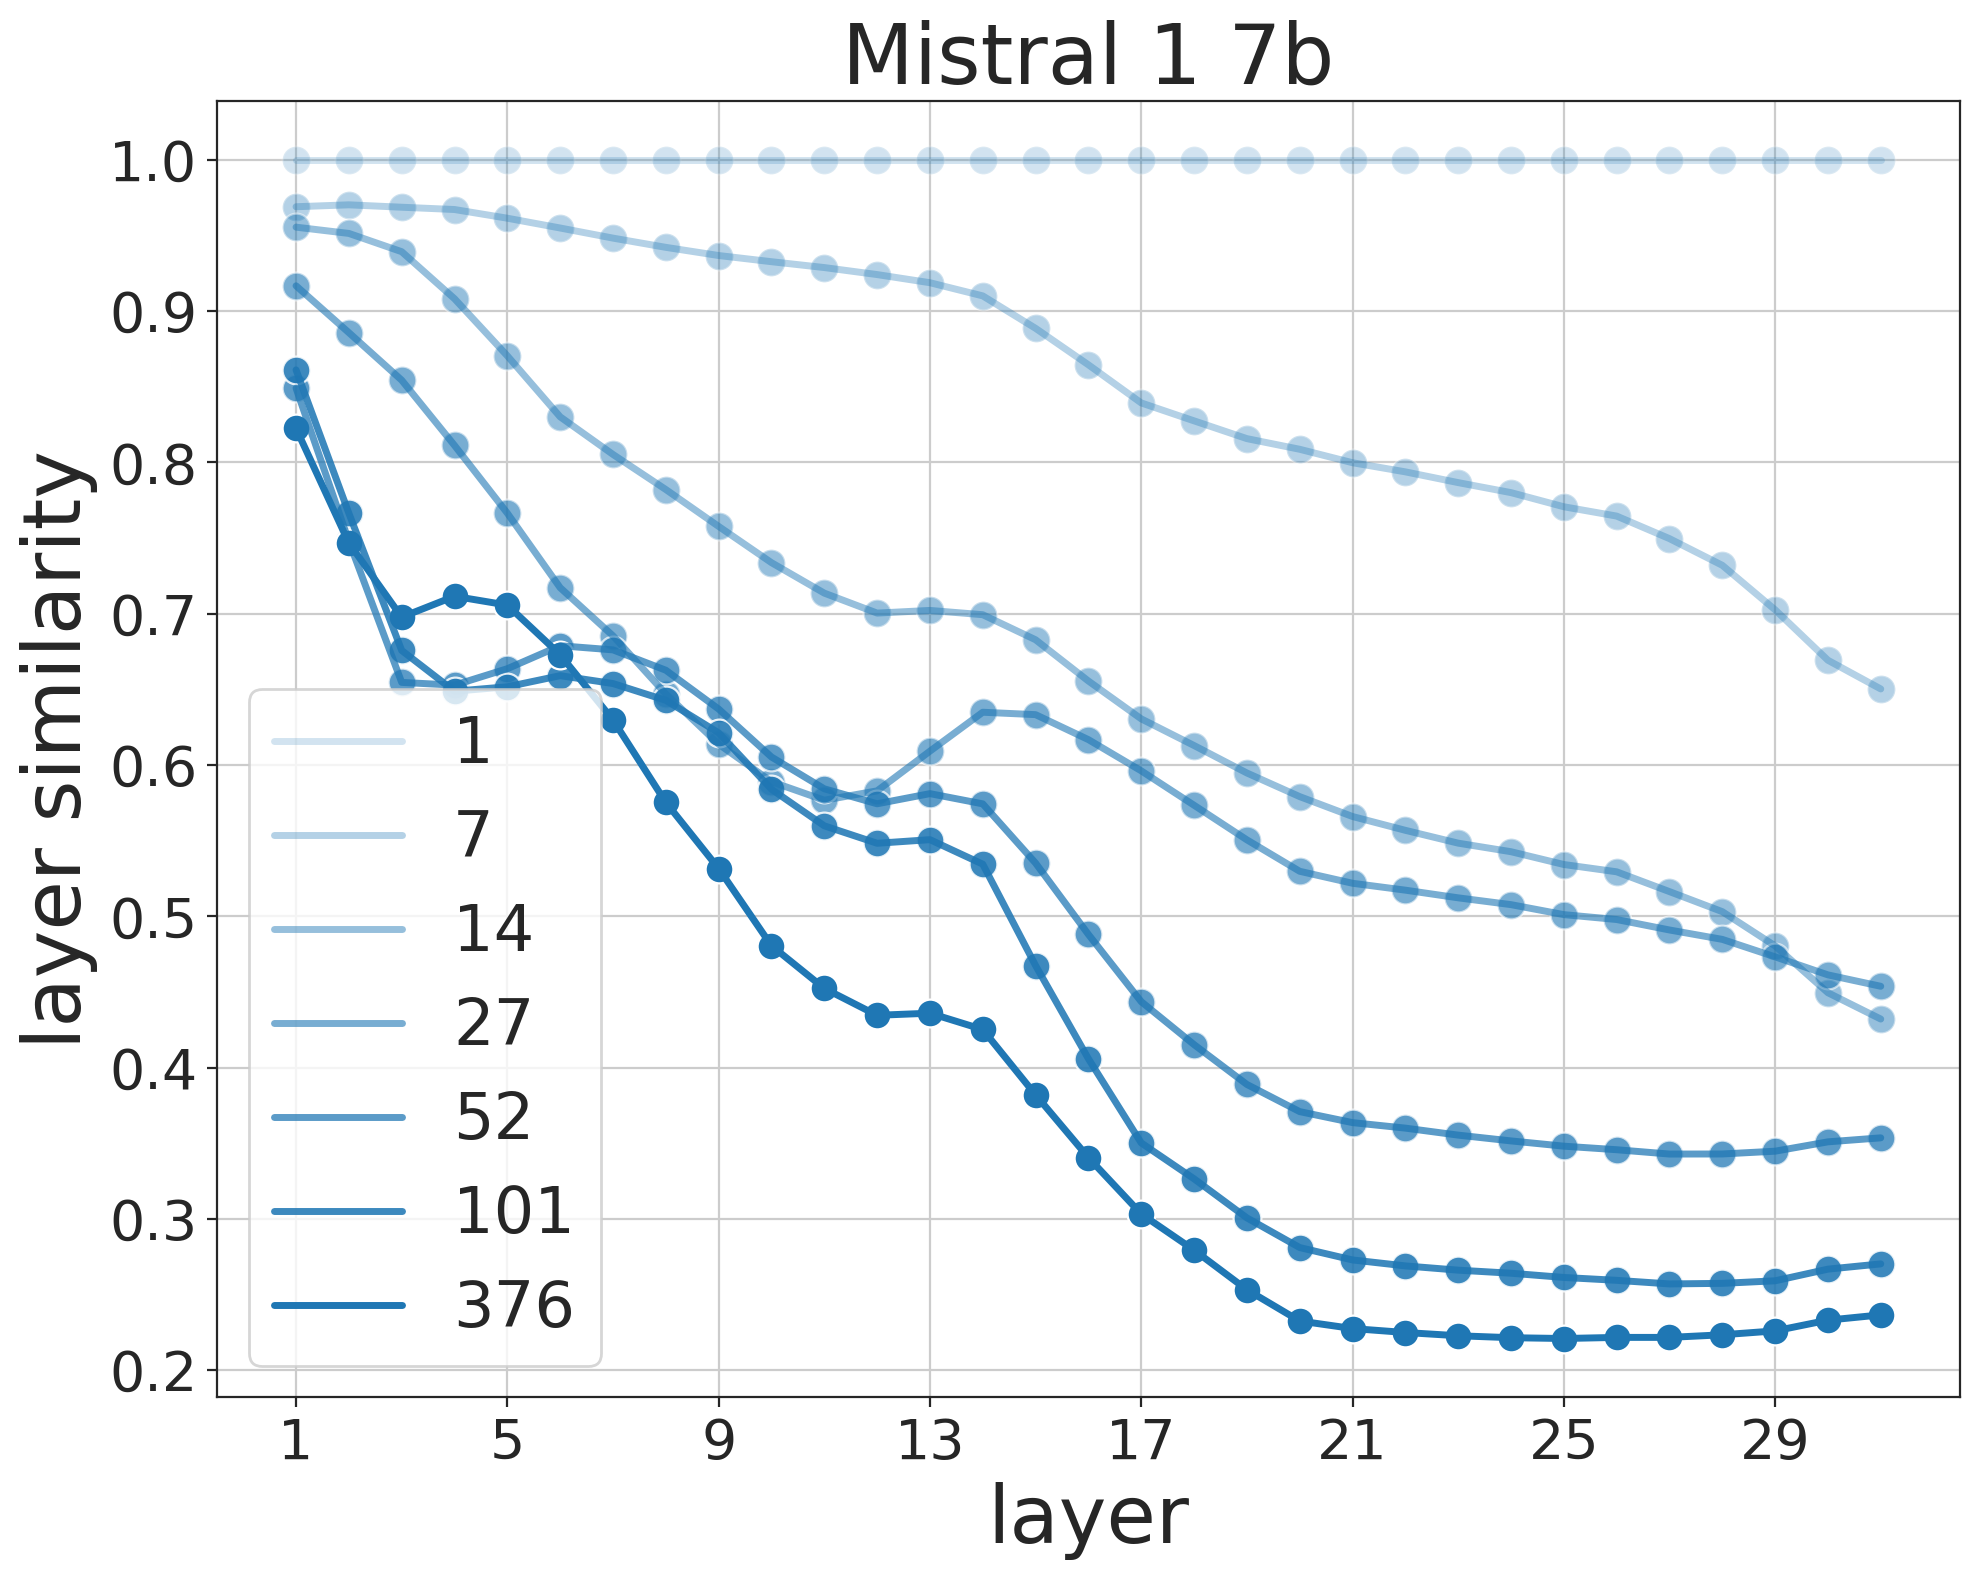

In [ ]:
if "dynamics_of_finetuning" in _METRICS:
    print("Dynamics of finetuning")

    # Representations for the dataset used for the finetuning
    _BASE_PATH = Path(f"/orfeo/cephfs/scratch/area/ddoimo/" \
                    f"open/geometric_lens/repo/results/" \
                    f"finetuned_dev_val_balanced_40samples/" \
                    f"evaluated_dev+validation/{model_name}/" \
                    f"6epochs/epoch_0")
    
    # Representations for different checkpoints of the finetuning
    _CHKP_PATH = Path(f"/orfeo/cephfs/scratch/area/ddoimo/" \
                    f"open/geometric_lens/repo/results/" \
                    f"finetuned_dev_val_balanced_40samples/" \
                    f"evaluated_dev+validation/{model_name}/" \
                    f"6epochs/10ckpts/")
    
    if os.path.exists(_CACHE_PATH / f"chkp_overlap.npy"):
        chkp_overlap = np.load(_CACHE_PATH / f"chkp_overlap.npy")
    else:
        point_overlap = PointOverlap()
        
        # mask used to extract the representations of the dataset used for the finetuning
        mask = np.load("/u/dssc/zenocosini/geometry_icl_finetuning/assets/mask.npy")
        
        _CACHE_PATH = Path(f"cache/{model_name}/")
        _CACHE_PATH.mkdir(parents=True, exist_ok=True)
        
        base_tensors, _, _ = retrieve_from_storage(_BASE_PATH,
                                                full_tensor=True)
        if model_name == "llama-3-70b":
            base_tensors = base_tensors[:,mask[:-2]]
        else:
            base_tensors = base_tensors[:,mask]
        
        chkp_overlap = []
        
        # steps_of_ft = tqdm.tqdm([1, 2, 3, 6, 12, 22, 42, 77, 144, 268])
        # steps_of_ft = tqdm.tqdm([1, 2, 3, 5, 9, 16, 29, 50, 88, 153])
        # steps_of_ft = tqdm.tqdm([1, 2, 4, 9, 19, 40, 83, 173, 360, 752])
        steps_of_ft = tqdm.tqdm([1, 2, 4, 8, 17, 34, 68, 138, 279, 564])
        if model_name == "llama-3-70b":
            # steps_of_ft = tqdm.tqdm([1, 2, 4, 7, 13, 24, 44, 84, 158, 296])
            steps_of_ft = tqdm.tqdm([1, 2, 3, 6, 11, 19, 35, 63, 114, 206])

        for step_number in steps_of_ft:
            steps_of_ft.set_description(f"Computing metric for model {model_name}")              
            
            chkp_point_tensor, _, _ = retrieve_from_storage(_CHKP_PATH / f"step_{step_number}",
                                                            full_tensor=True)
            if model_name == "llama-3-70b":
                chkp_point_tensor = chkp_point_tensor[:,mask[:-2]]
            else:
                chkp_point_tensor = chkp_point_tensor[:, mask]
            
            # Compute neighborhood overlap between the base and the checkpoint tensors
            output = point_overlap.main(input_i=base_tensors,
                                        input_j=chkp_point_tensor,
                                        number_of_layers=base_tensors.shape[0],
                                        k=30)
            chkp_overlap.append(output)
                
        chkp_overlap = np.stack(chkp_overlap)
        np.save( _CACHE_PATH / f"point_overlap.npy", chkp_overlap)
    
chkp_overlap = [chkp_overlap[i] for i in range(len(chkp_overlap))]

# Plot overlap
title = model_name[0].upper() + model_name[1:]
plot_overlap(chkp_overlap, title, 2)
